In [188]:
import re
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import random
import math
import os
from bokeh.plotting import figure, output_file, show
from bokeh.models import Range1d
from bokeh.embed import components

In [189]:
%matplotlib inline

In [190]:
def get_filename_components(filename):
    frase = r"(?<=dE2000_out_).+(?=_)"
    match = re.findall(frase, filename)
    algo, target, tools, opt = match[0].split("_")
    tools = tools.split("-")
    return algo, target, tools[0], tools[1], opt

In [206]:
def get_dE2000_values(filepath, filename):
    values = []
    frames = []
    mean_deltaE = []
    max_deltaE = []
    sm_deltaE = []
    gmax_deltaE = []
    gsm_deltaE = []
    # sm uses a smoothening filter
    regex1 = r"^\s+\d+\s\d+\.\d+\s\d+\.\d+"
    regex2 = r"(?P<index>sm\s+)(?P<value>\d+\.\d+)"
    regex3 = r"\s{3}Max\s"
    regex4 = r"\s{10}sm\s"
    read_log = open(filepath + filename)
    for txt_line in read_log:
        values_found = re.findall(regex1, txt_line)
        sm_deltaE_found = re.findall(regex2, txt_line)
        gmax_deltaE_found = re.findall(r"(?<={})\d+\.\d+".format(regex3), txt_line)
        gsm_deltaE_found = re.findall(r"(?<={})\d+\.\d+".format(regex4), txt_line)
        [values.append(value) for value in values_found if len(value) > 0]
        [sm_deltaE.append(sm[1]) for sm in sm_deltaE_found if len(sm_deltaE_found) > 0]
        [gmax_deltaE.append(gmax) for gmax in gmax_deltaE_found if len(gmax_deltaE_found) > 0]
        [gsm_deltaE.append(gsm) for gsm in gsm_deltaE_found if len(gsm_deltaE_found) > 0]
    read_log.close()
    for v in values:
        frame, mean, max_ = v.split()
        frames.append(frame)
        mean_deltaE.append(mean)
        max_deltaE.append(max_)
    muell = sm_deltaE.pop(-1)
    return frames, mean_deltaE, max_deltaE, sm_deltaE, gmax_deltaE, gsm_deltaE

In [207]:
path = "/Users/hquos/Projects/DSV_libdm4/logs/01_DvDmApp/dE2000/030/"
file = "dE2000_out_dm4_t1_BER-SUN_opt-avx2_win.txt"
get_dE2000_values(path, file)

(['0',
  '1',
  '2',
  '3',
  '4',
  '5',
  '6',
  '7',
  '8',
  '9',
  '10',
  '11',
  '12',
  '13',
  '14',
  '15',
  '16',
  '17',
  '18',
  '19',
  '20',
  '21',
  '22',
  '23',
  '24',
  '25',
  '26',
  '27',
  '28',
  '29',
  '30',
  '31',
  '32',
  '33',
  '34',
  '35',
  '36',
  '37',
  '38',
  '39',
  '40',
  '41',
  '42',
  '43',
  '44',
  '45',
  '46',
  '47',
  '48',
  '49',
  '50',
  '51',
  '52',
  '53',
  '54',
  '55',
  '56',
  '57',
  '58',
  '59',
  '60',
  '61',
  '62',
  '63',
  '64',
  '65',
  '66',
  '67',
  '68',
  '69',
  '70',
  '71',
  '72',
  '73',
  '74',
  '75',
  '76',
  '77',
  '78',
  '79',
  '80',
  '81',
  '82',
  '83',
  '84',
  '85',
  '86',
  '87',
  '88',
  '89',
  '90',
  '91',
  '92',
  '93',
  '94',
  '95',
  '96',
  '97',
  '98',
  '99',
  '100',
  '101',
  '102',
  '103',
  '104',
  '105',
  '106',
  '107',
  '108',
  '109',
  '110',
  '111',
  '112',
  '113',
  '114',
  '115',
  '116',
  '117',
  '118',
  '119',
  '120',
  '121',
  '122',
  '

### This function (draw_ictcp) contains the main functionality and calls the two previoues functions:

In [216]:
def draw_ictcp(file, inpath, outpath):
    algo, target, tools1, tools2, opt = get_filename_components(file)
    frames, mean_deltaE, max_deltaE, sm_deltaE, gmax_deltaE, gsm_deltaE = get_dE2000_values(inpath, file)
    name = "_".join((tools1, tools2, algo, target, opt))
    index = ['Source1', 'Source2', 'DM Algo', 'Target', 'Frame', 
             'DeltaE CIE2000 mean', 'DeltaE CIE2000 max', 'smoothed dE2000 max',
             'DeltaE CIE2000 global max', 'DeltaE CIE2000 global smoothed max']
    content = []
    if len(frames) == len(mean_deltaE) == len(max_deltaE) == len(sm_deltaE) and len(gmax_deltaE) == len(gsm_deltaE) == 1:
        print("Reading --> " + name)
    else:
        print("Date extraction not possible! \n Please check log file for completeness or format.")
    for f in range(0, len(frames), 1):
        temp = [tools1, tools2, algo, target, frames[f], 
                mean_deltaE[f], 
                max_deltaE[f], 
                sm_deltaE[f], 
                gmax_deltaE[0], 
                gsm_deltaE[0]]
        content.append(temp)
    # data prep
    df = pd.DataFrame(list(np.array(content).T), index=index)
    l_dict = {'t1': '100', 't27': '600', 't49': '1000'}
    nr_frame = int(df.columns[-1])
    x = range(len(df.columns))

    y_max = [float(y) for y in df.loc['DeltaE CIE2000 max']]
    y_avg = [float(y) for y in df.loc['DeltaE CIE2000 mean']]
    y_sm = [float(y) for y in df.loc['smoothed dE2000 max']]
    y_th10 = [1 for i in range(0, int(len(x)))]
    y_th25 = [2.5 for i in range(0, int(len(x)))]                           
    max_yticks = math.ceil(max(y_max))
    if max_yticks < 3:
        max_yticks = 3
    # draw matplotlib plot
    plt.figure(figsize=(10, 6))
    plt.plot(x, y_max, 'b.', label = 'DeltaE CIE2000 max')
    plt.plot(x, y_avg, 'c.', label = 'DeltaE CIE2000 mean')
    plt.plot(x, y_sm, 'y.', label = 'DeltaE CIE2000 max smoothed')
    plt.plot(range(0,nr_frame), [1,]*nr_frame, 'g', label = 'Threshold of 1 JND', linestyle='dotted')
    plt.plot(range(0,nr_frame), [2.5,]*nr_frame, 'r', label = 'Threshold of 2.5 JND', linestyle='dotted')
    plt.yticks(range(0, max_yticks, math.ceil(max_yticks/10)))
    plt.xticks(range(0, 155, 20))
    plt.xlabel('number of frames')
    plt.ylabel('DeltaE CIE2000 error level')
    title = f'Target {target[1:]} - {l_dict[target]}nits image quality comparison of {tools1} {opt} vs. {tools2} {str.upper(algo)} modul'
    plt.title(title)
    plt.legend()
    plt.savefig(outpath + file.split('.')[0] + ".png", dpi=200)
    
    # prep bokeh plot & output to static HTML file
    # TODO output HTML only if DATA not NULL
    output_file(outpath + file.split('.')[0] + ".html")
    tools = ["pan","box_zoom","hover","reset","save"]
    TOOLTIPS = [
        ("Frame", "$index"),
        ("JND", "$y")
    ]
    p = figure(
        tools=tools, tooltips=TOOLTIPS, toolbar_location="above",
        y_range=[0, max_yticks], title=title,
        x_axis_label='Number of frames', y_axis_label='DeltaE CIE2000  error level in JND',
        plot_width=1000, plot_height=500)
    # add bokeh renderers for each graph (y value)
    p.line(x, y_th10, legend_label='Threshold of 1 JND', line_color="green", line_dash="4 4", line_width=2, alpha=0.5)
    p.line(x, y_th25, legend_label='Threshold of 2.5 JND', line_color="red", line_dash="4 4", line_width=2, alpha=0.5)
    p.line(x, y_max, legend_label='DeltaE CIE2000 max')
    p.circle(x, y_max, legend_label='DeltaE CIE2000 max', fill_color="white", fill_alpha=0.4, size=8)
    p.line(x, y_avg, legend_label='DeltaE CIE2000 mean', line_color="cyan")
    p.circle(x, y_avg, legend_label='DeltaE CIE2000 mean', fill_color="white", fill_alpha=0.4, line_color="cyan", size=8)
    p.line(x, y_sm, legend_label='DeltaE CIE2000 max smoothed', line_color="orange")
    p.circle(x, y_sm, legend_label='DeltaE CIE2000 max smoothed', fill_color="white", fill_alpha=0.4, line_color="orange", size=8)
    # show the results
    show(p)

### prep files for processing:

In [213]:
# enter path containing logfiles here:
mainpath = "/Users/hquos/Projects/DSV_libdm4/logs/01_DvDmApp/dE2000/"

In [214]:
main_content = glob.glob(mainpath + "**/")
subdirs = [dirpath.split("/") for dirpath in main_content]
cases = [subdir[-2] for subdir in subdirs]
cases_path = [mainpath+c for c in cases]

[Errno 17] File exists: '/Users/hquos/Projects/DSV_libdm4/plots/DvDmApp_19-11-2020/092541000/'
Processing --> 092541000
Reading --> BER_SUN_dm3_t49_opt-avx2
Reading --> BER_SUN_dm3_t27_opt-avx2
Reading --> BER_SUN_dm4_t49_no-opt
Reading --> BER_SUN_dm3_t49_no-opt
Reading --> BER_SUN_dm3_t1_opt-avx2
Reading --> BER_SUN_dm4_t49_opt-avx2
Reading --> BER_SUN_dm4_t27_opt-avx2
Reading --> BER_SUN_dm4_t1_opt-avx2
Reading --> BER_SUN_dm4_t27_no-opt
Reading --> BER_SUN_dm4_t1_no-opt
Reading --> BER_SUN_dm3_t1_no-opt
Reading --> BER_SUN_dm3_t27_no-opt
[Errno 17] File exists: '/Users/hquos/Projects/DSV_libdm4/plots/DvDmApp_19-11-2020/092541013/'
Processing --> 092541013
Reading --> BER_SUN_dm3_t49_opt-avx2
Reading --> BER_SUN_dm3_t27_opt-avx2
Reading --> BER_SUN_dm4_t49_no-opt
Reading --> BER_SUN_dm3_t49_no-opt
Reading --> BER_SUN_dm3_t1_opt-avx2
Reading --> BER_SUN_dm4_t49_opt-avx2
Reading --> BER_SUN_dm4_t27_opt-avx2
Reading --> BER_SUN_dm4_t1_opt-avx2
Reading --> BER_SUN_dm4_t27_no-opt


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Reading --> BER_SUN_dm4_t1_no-opt


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Reading --> BER_SUN_dm3_t1_no-opt


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Reading --> BER_SUN_dm3_t27_no-opt


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


[Errno 17] File exists: '/Users/hquos/Projects/DSV_libdm4/plots/DvDmApp_19-11-2020/092541003/'
Processing --> 092541003
Reading --> BER_SUN_dm3_t49_opt-avx2


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Reading --> BER_SUN_dm3_t27_opt-avx2


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Reading --> BER_SUN_dm4_t49_no-opt


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Reading --> BER_SUN_dm3_t49_no-opt


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Reading --> BER_SUN_dm3_t1_opt-avx2


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Reading --> BER_SUN_dm4_t49_opt-avx2


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Reading --> BER_SUN_dm4_t27_opt-avx2


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Reading --> BER_SUN_dm4_t1_opt-avx2


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Reading --> BER_SUN_dm4_t27_no-opt


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Reading --> BER_SUN_dm4_t1_no-opt


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Reading --> BER_SUN_dm3_t1_no-opt


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Reading --> BER_SUN_dm3_t27_no-opt


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


[Errno 17] File exists: '/Users/hquos/Projects/DSV_libdm4/plots/DvDmApp_19-11-2020/092541010/'
Processing --> 092541010
Reading --> BER_SUN_dm3_t49_opt-avx2


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Reading --> BER_SUN_dm3_t27_opt-avx2


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Reading --> BER_SUN_dm4_t49_no-opt


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Reading --> BER_SUN_dm3_t49_no-opt


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Reading --> BER_SUN_dm3_t1_opt-avx2


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Reading --> BER_SUN_dm4_t49_opt-avx2


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Reading --> BER_SUN_dm4_t27_opt-avx2


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Reading --> BER_SUN_dm4_t1_opt-avx2


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Reading --> BER_SUN_dm4_t27_no-opt


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Reading --> BER_SUN_dm4_t1_no-opt


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Reading --> BER_SUN_dm3_t1_no-opt


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Reading --> BER_SUN_dm3_t27_no-opt


/Users/hquos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


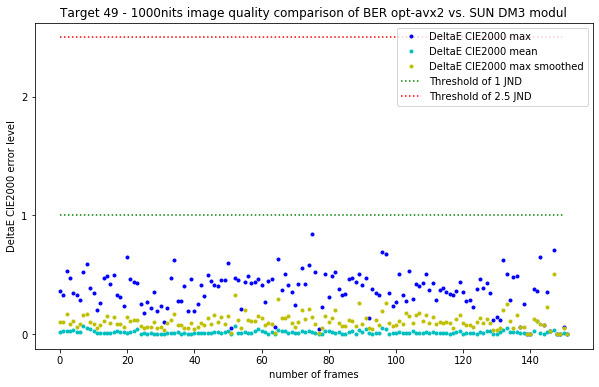

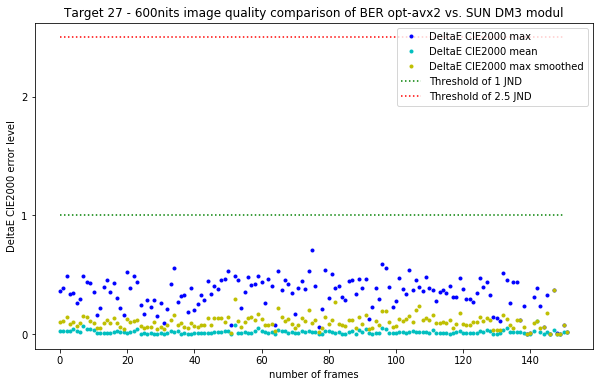

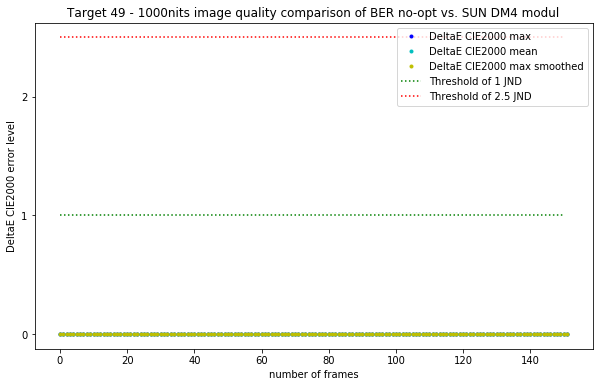

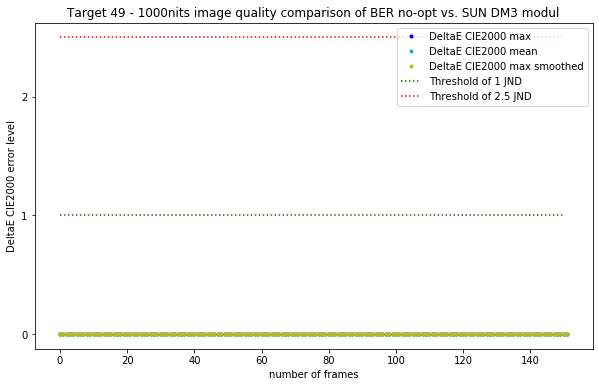

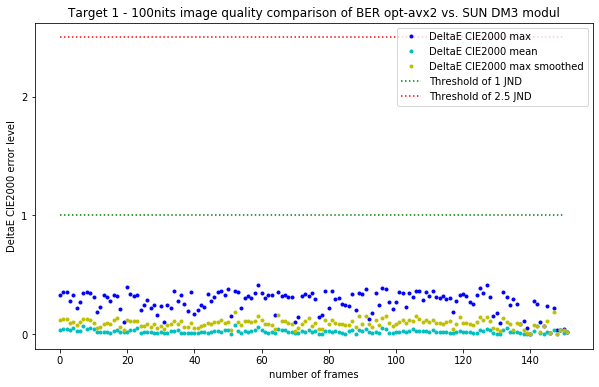

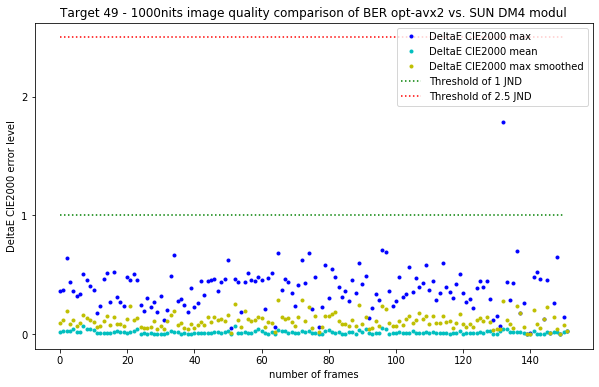

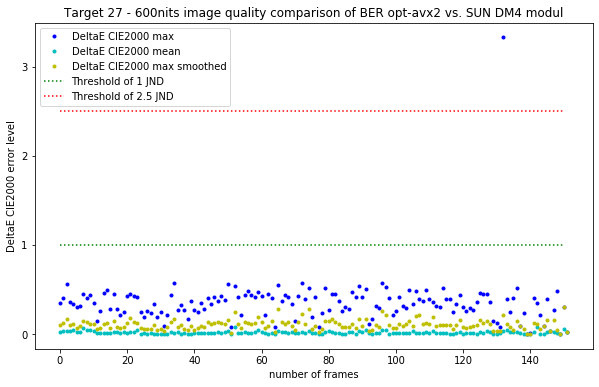

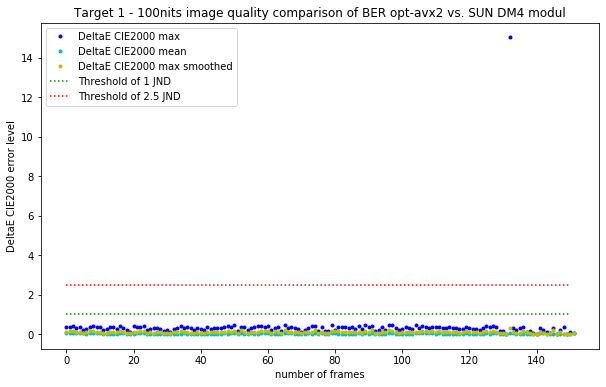

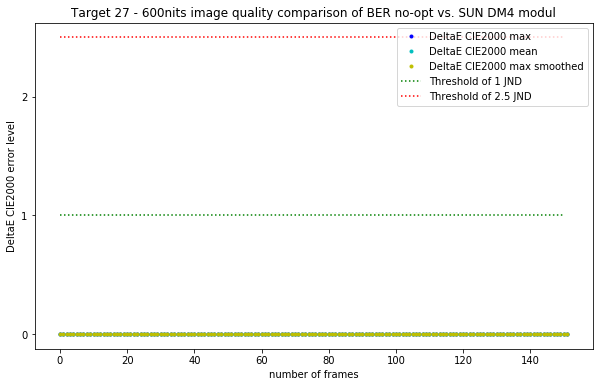

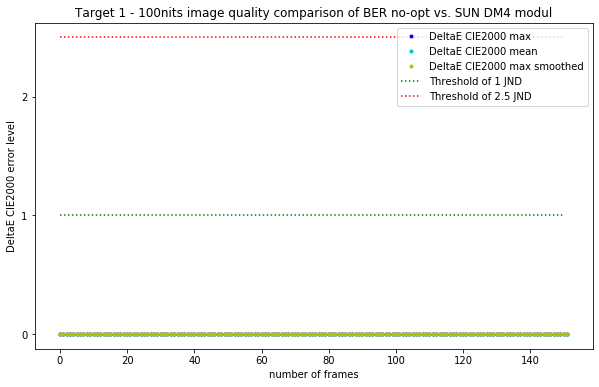

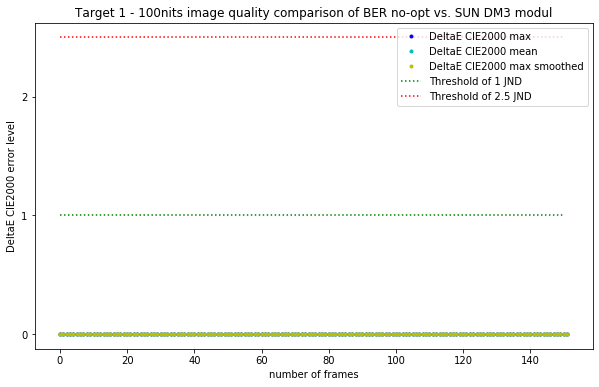

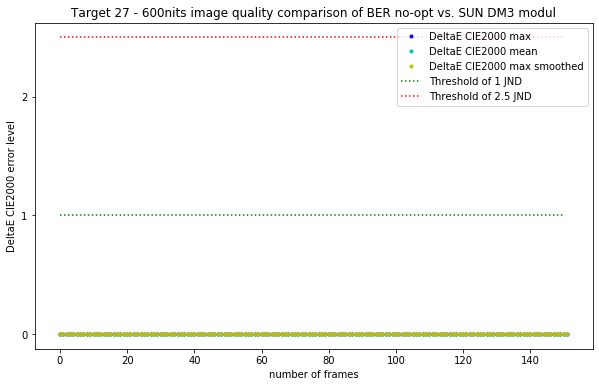

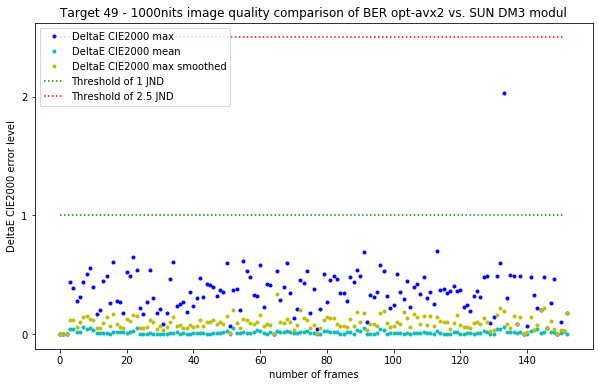

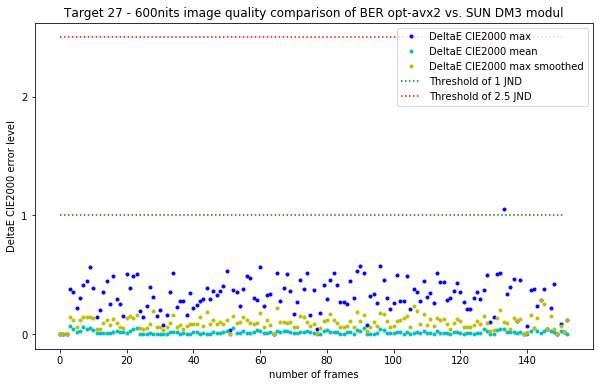

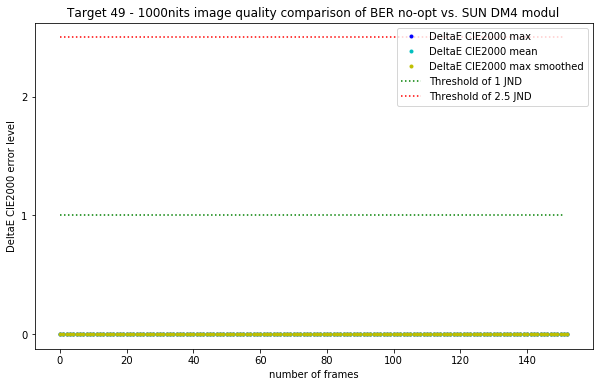

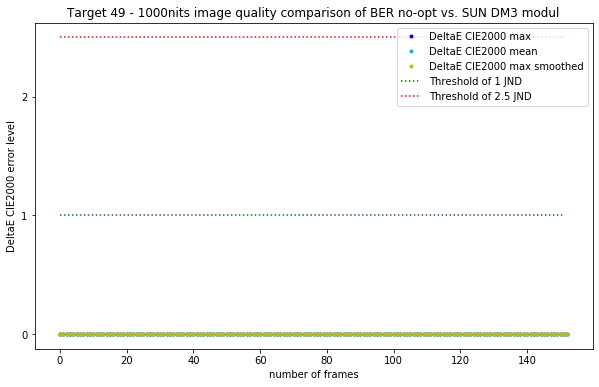

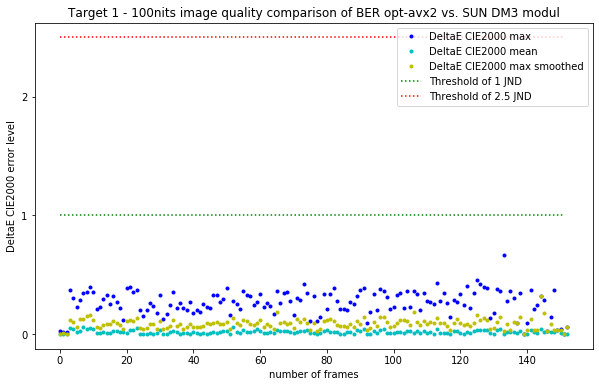

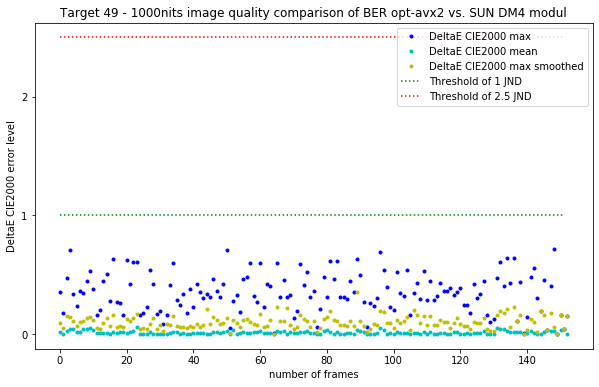

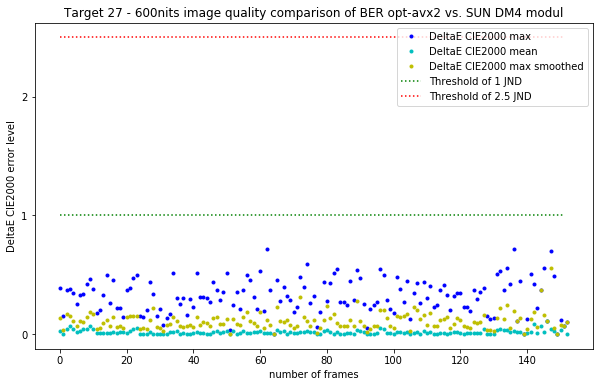

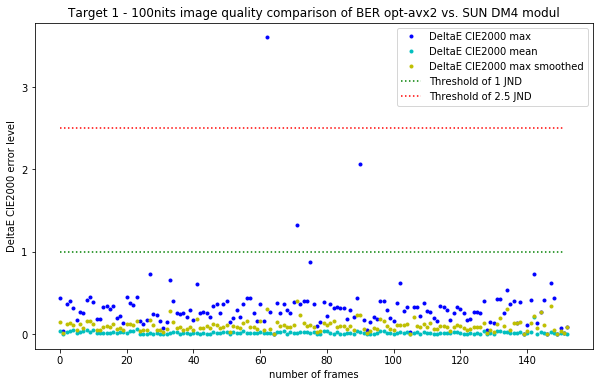

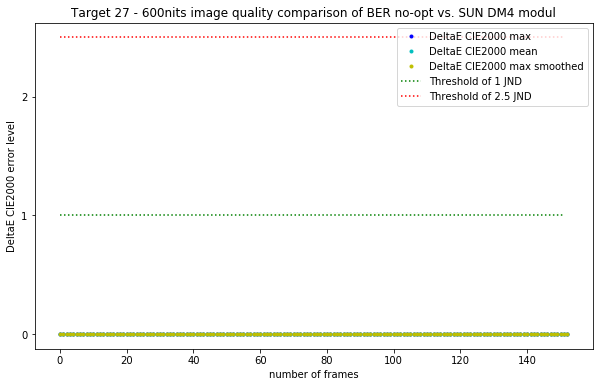

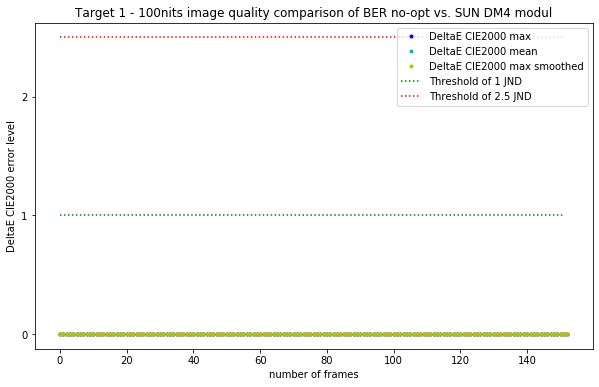

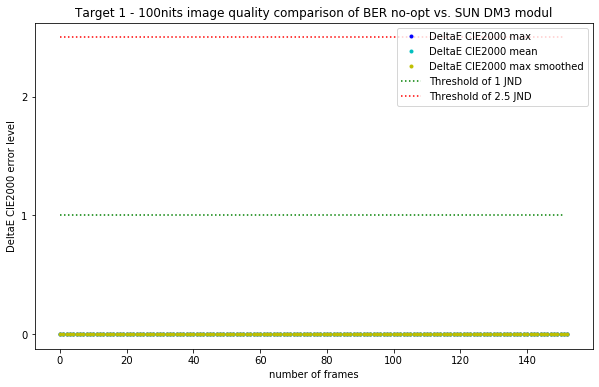

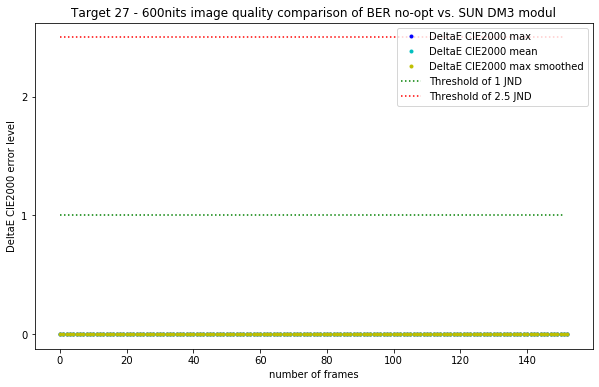

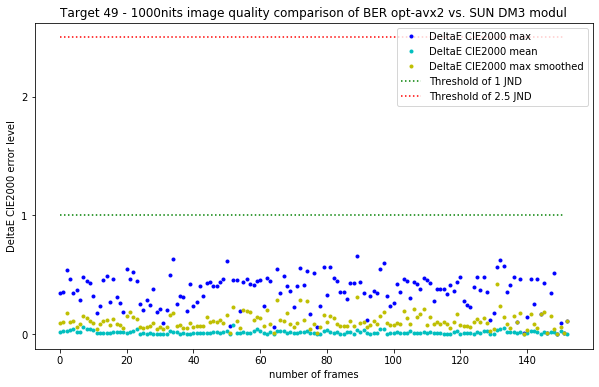

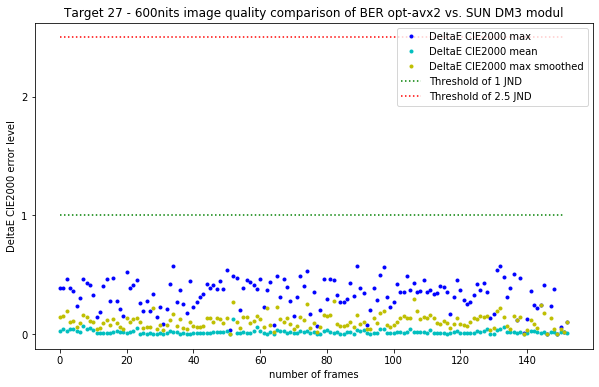

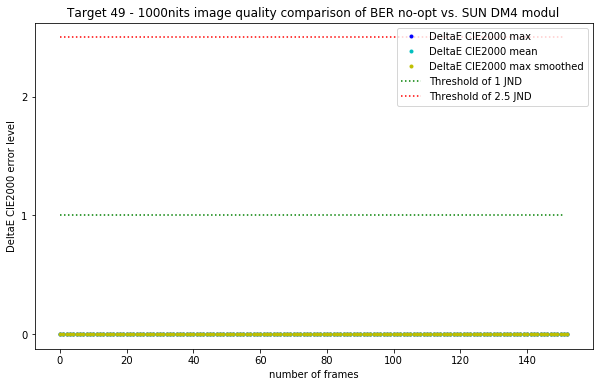

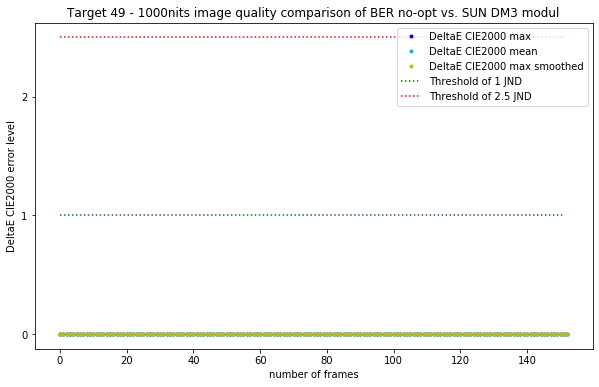

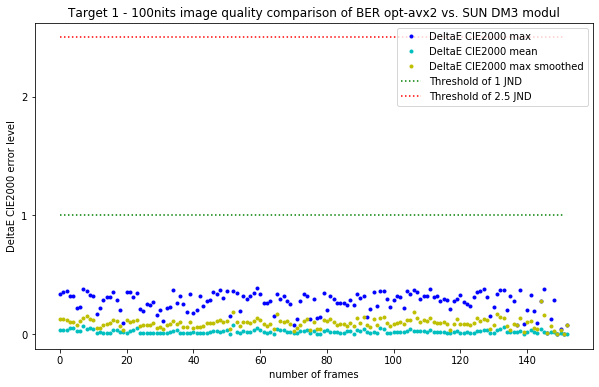

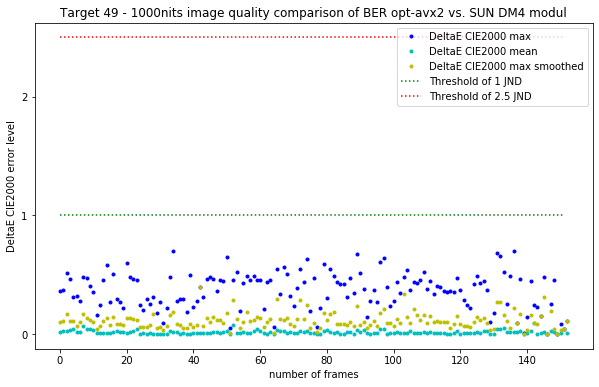

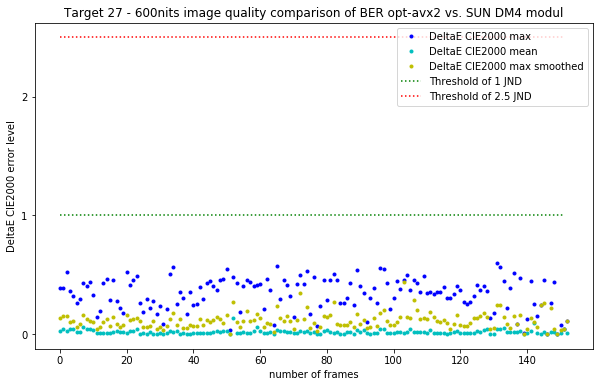

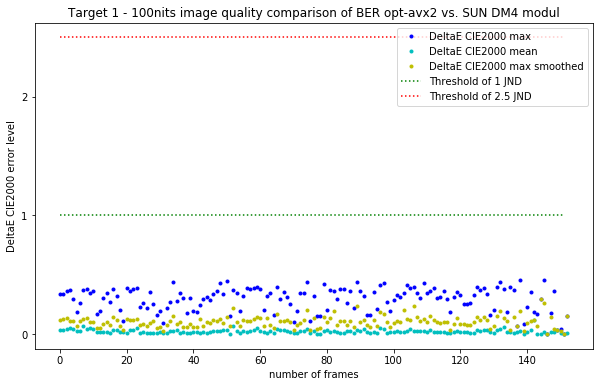

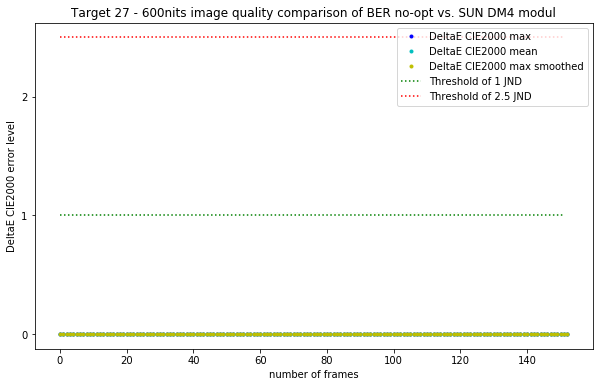

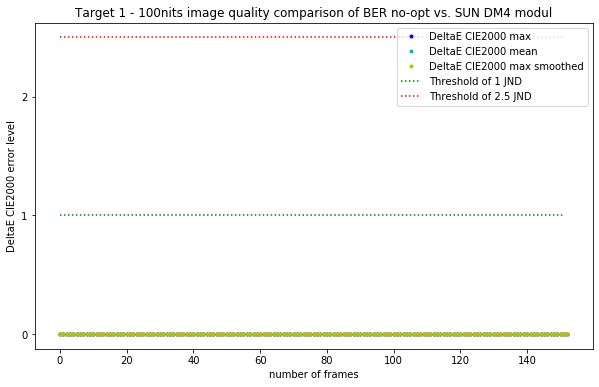

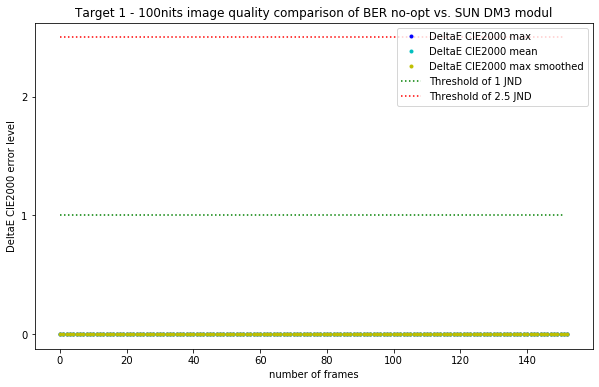

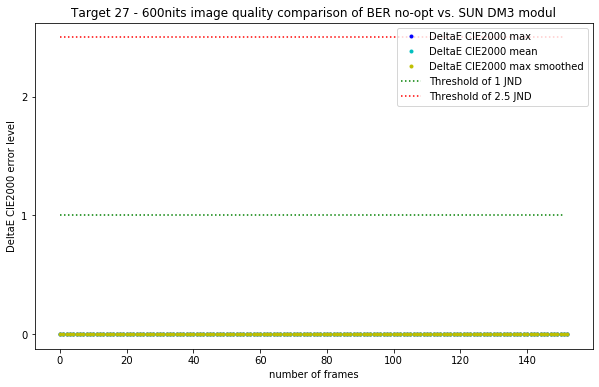

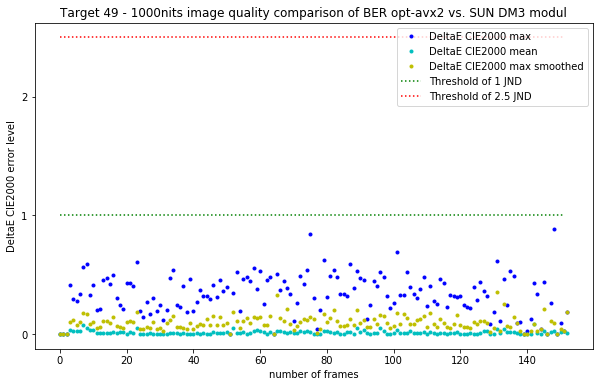

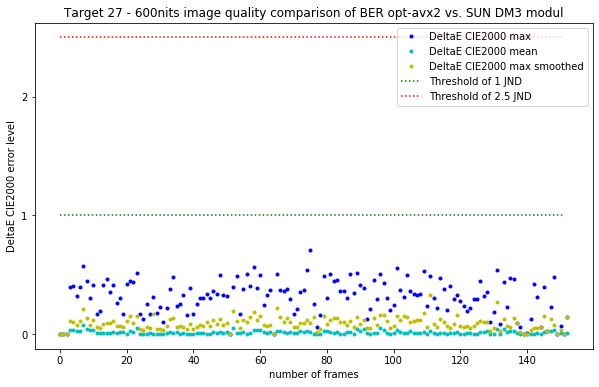

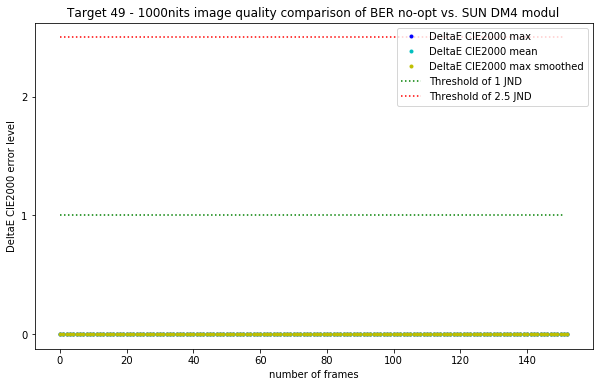

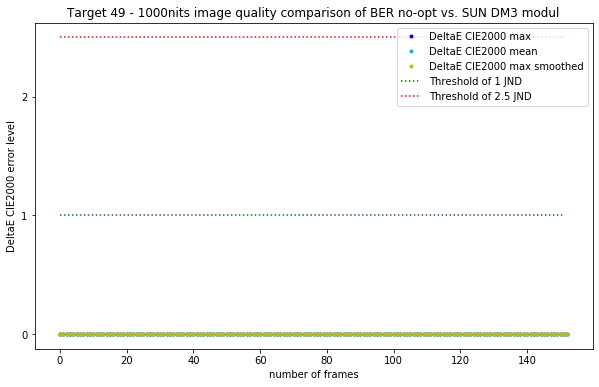

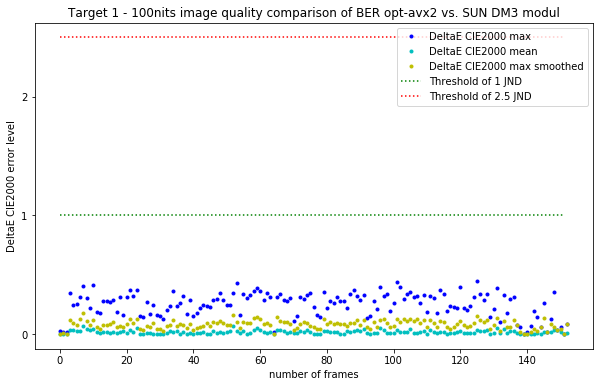

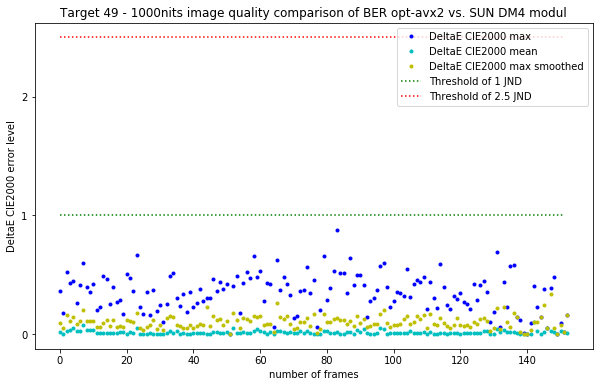

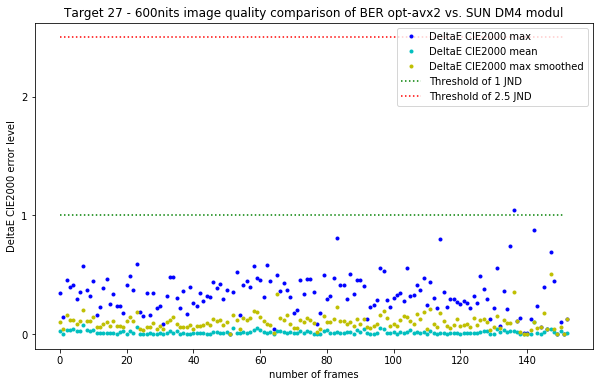

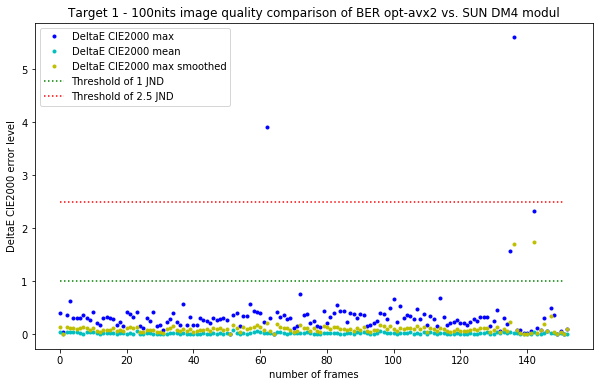

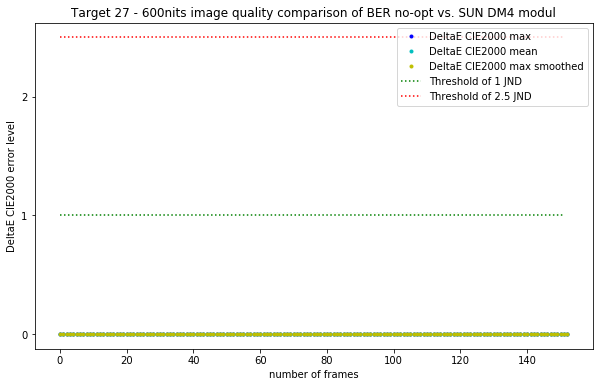

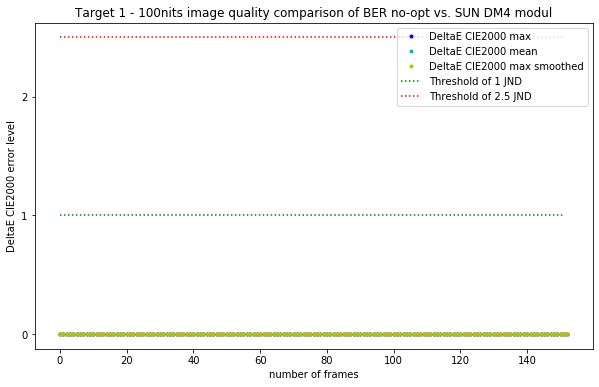

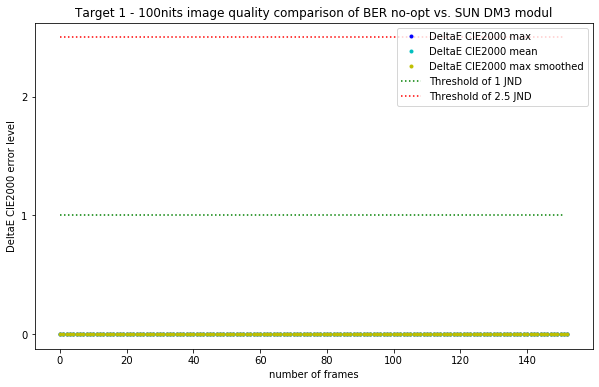

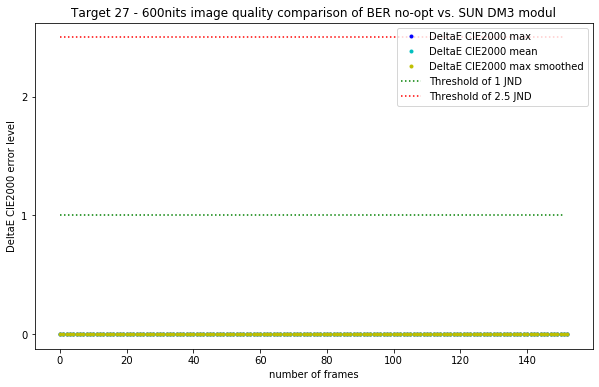

In [217]:
for case in cases_path:
    cases_content = glob.glob(case + "/*.*")
    full_paths = [p.split("/") for p in cases_content]
    files = [p.pop(-1) for p in full_paths]
    outpath = "/Users/hquos/Projects/DSV_libdm4/plots/DvDmApp_19-11-2020/" + case.split("/")[-1] + "/"
    try:
        os.mkdir(outpath) 
    except OSError as error: 
        print(error)
    print("Processing --> " + case.split("/")[-1])
    for file in files:
        df_log = draw_ictcp(file, case+"/", outpath)

## ToDo:
* write df in csv file for processing in Jenkins
* or only export max ICtCp value for threshold trigger